In [5]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf

from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("../functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots
import SCA

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [6]:
modelpath = "../models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec_ERSST = np.arange(1854+3*run+leadtime,2024,)
obsyearvec_HadISST = np.arange(1870+3*run+leadtime,2024,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)
latvec = np.arange(-90+inres/2,90+inres/2,inres)
lonvec = np.arange(0+inres/2,360+inres/2,inres)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

In [7]:
datafile = "../processed_data/" + filefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

trainvaltest = [trainvariants,valvariants,testvariants]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

nvars = int(len(valvariants)*len(modellist))
nvariant = len(testvariants)
nmodels = len(modellist)
ntimesteps = int(len(outputtest)/(nvariant*nmodels))
n1model = ntimesteps*nvariant

mask = np.copy(outputtest)
mask[mask==0] = np.nan
landmask = ~np.isnan(np.mean(mask,axis=0))
latweights[~landmask] = 0

model_polydetrend_filename = "../processed_data/" + filefront + "_imodel_polydetrend.npz"

inputtest_polydetrend,outputtest_polydetrend = preprocessing.get_polydetrend_test(experiment_dict,model_polydetrend_filename,testvariants,ntimesteps)

inputtest_polydetrend[:,np.isnan(np.mean(inputtest_polydetrend,axis=0))] = 0
outputtest_polydetrend = outputtest_polydetrend/outputstd
outputtest_polydetrend[:,np.isnan(np.mean(outputtest_polydetrend,axis=0))] = 0

inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_obs(experiment_dict,"ERSST")
inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,run)

inputobs_HadISST,outputobs_HadISST = preprocessing.make_inputoutput_obs(experiment_dict,"HadISST")
inputobs_HadISST,outputobs_HadISST = preprocessing.concatobs(inputobs_HadISST,outputobs_HadISST,outputstd,run)

conversion done


In [8]:
def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def model_member_corr(pattern,outputtest,y_pred_test,nmodels,nvariant,landmask):
    
    modelpearsons = np.empty((nmodels,nvariant))
    modelps = np.empty((nmodels,nvariant))
    
    #modelpearsonsall = np.empty((nmodels))

    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,landmask)
    
    return modelpearsons

def weightedMSE(y_pred,y_true,weights):
    err = ((y_pred-y_true)*weights)
    sqerr = err**2
    mse = np.mean(sqerr)
    return mse

In [9]:
domainMSE = []

for random_seed in seedlist:

    fileout = filename + "_seed=" + str(random_seed) +".h5"

    tf.random.set_seed(random_seed)
    np.random.seed(random_seed) 
    
    full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                    experiment_dict, random_seed)  
    
    full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                        loss=tf.keras.losses.MeanSquaredError(), 
                      )

    full_model.load_weights(fileout)
    
    full_model.trainable = False # freeze BN

    y_pred_val = full_model.predict(inputval) 
    
    mse = weightedMSE(y_pred_val,outputval,latweights)
    domainMSE.append(mse)

domainMSE = np.asarray(domainMSE)
bestseed = np.argmin(domainMSE)


336/336 [==============================] - 1s 4ms/step


In [10]:
imp.reload(analysisplots)
#for random_seed in seedlist[1:2]:

random_seed = seedlist[bestseed]

fileout = filename + "_seed=" + str(random_seed) +".h5"

tf.random.set_seed(random_seed)
np.random.seed(random_seed) 

full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                experiment_dict, random_seed)  

full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                    loss=tf.keras.losses.MeanSquaredError(), 
                  )

full_model.load_weights(fileout)

full_model.trainable = False # freeze BN

y_pred_test = full_model.predict(inputtest)
# y_pred_val = full_model.predict(inputval) 
y_pred_test_polydetrend = full_model.predict(inputtest_polydetrend)

y_pred_obs_ERSST = full_model.predict(inputobs_ERSST)
y_pred_obs_ERSST[:,np.sum(outputobs_ERSST,axis=0)==0]=0 # zero out land points

y_pred_obs_HadISST = full_model.predict(inputobs_HadISST)
y_pred_obs_HadISST[:,np.sum(outputobs_HadISST,axis=0)==0]=0 # zero out land points

bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   


5/5 [==============================] - 0s 4ms/step


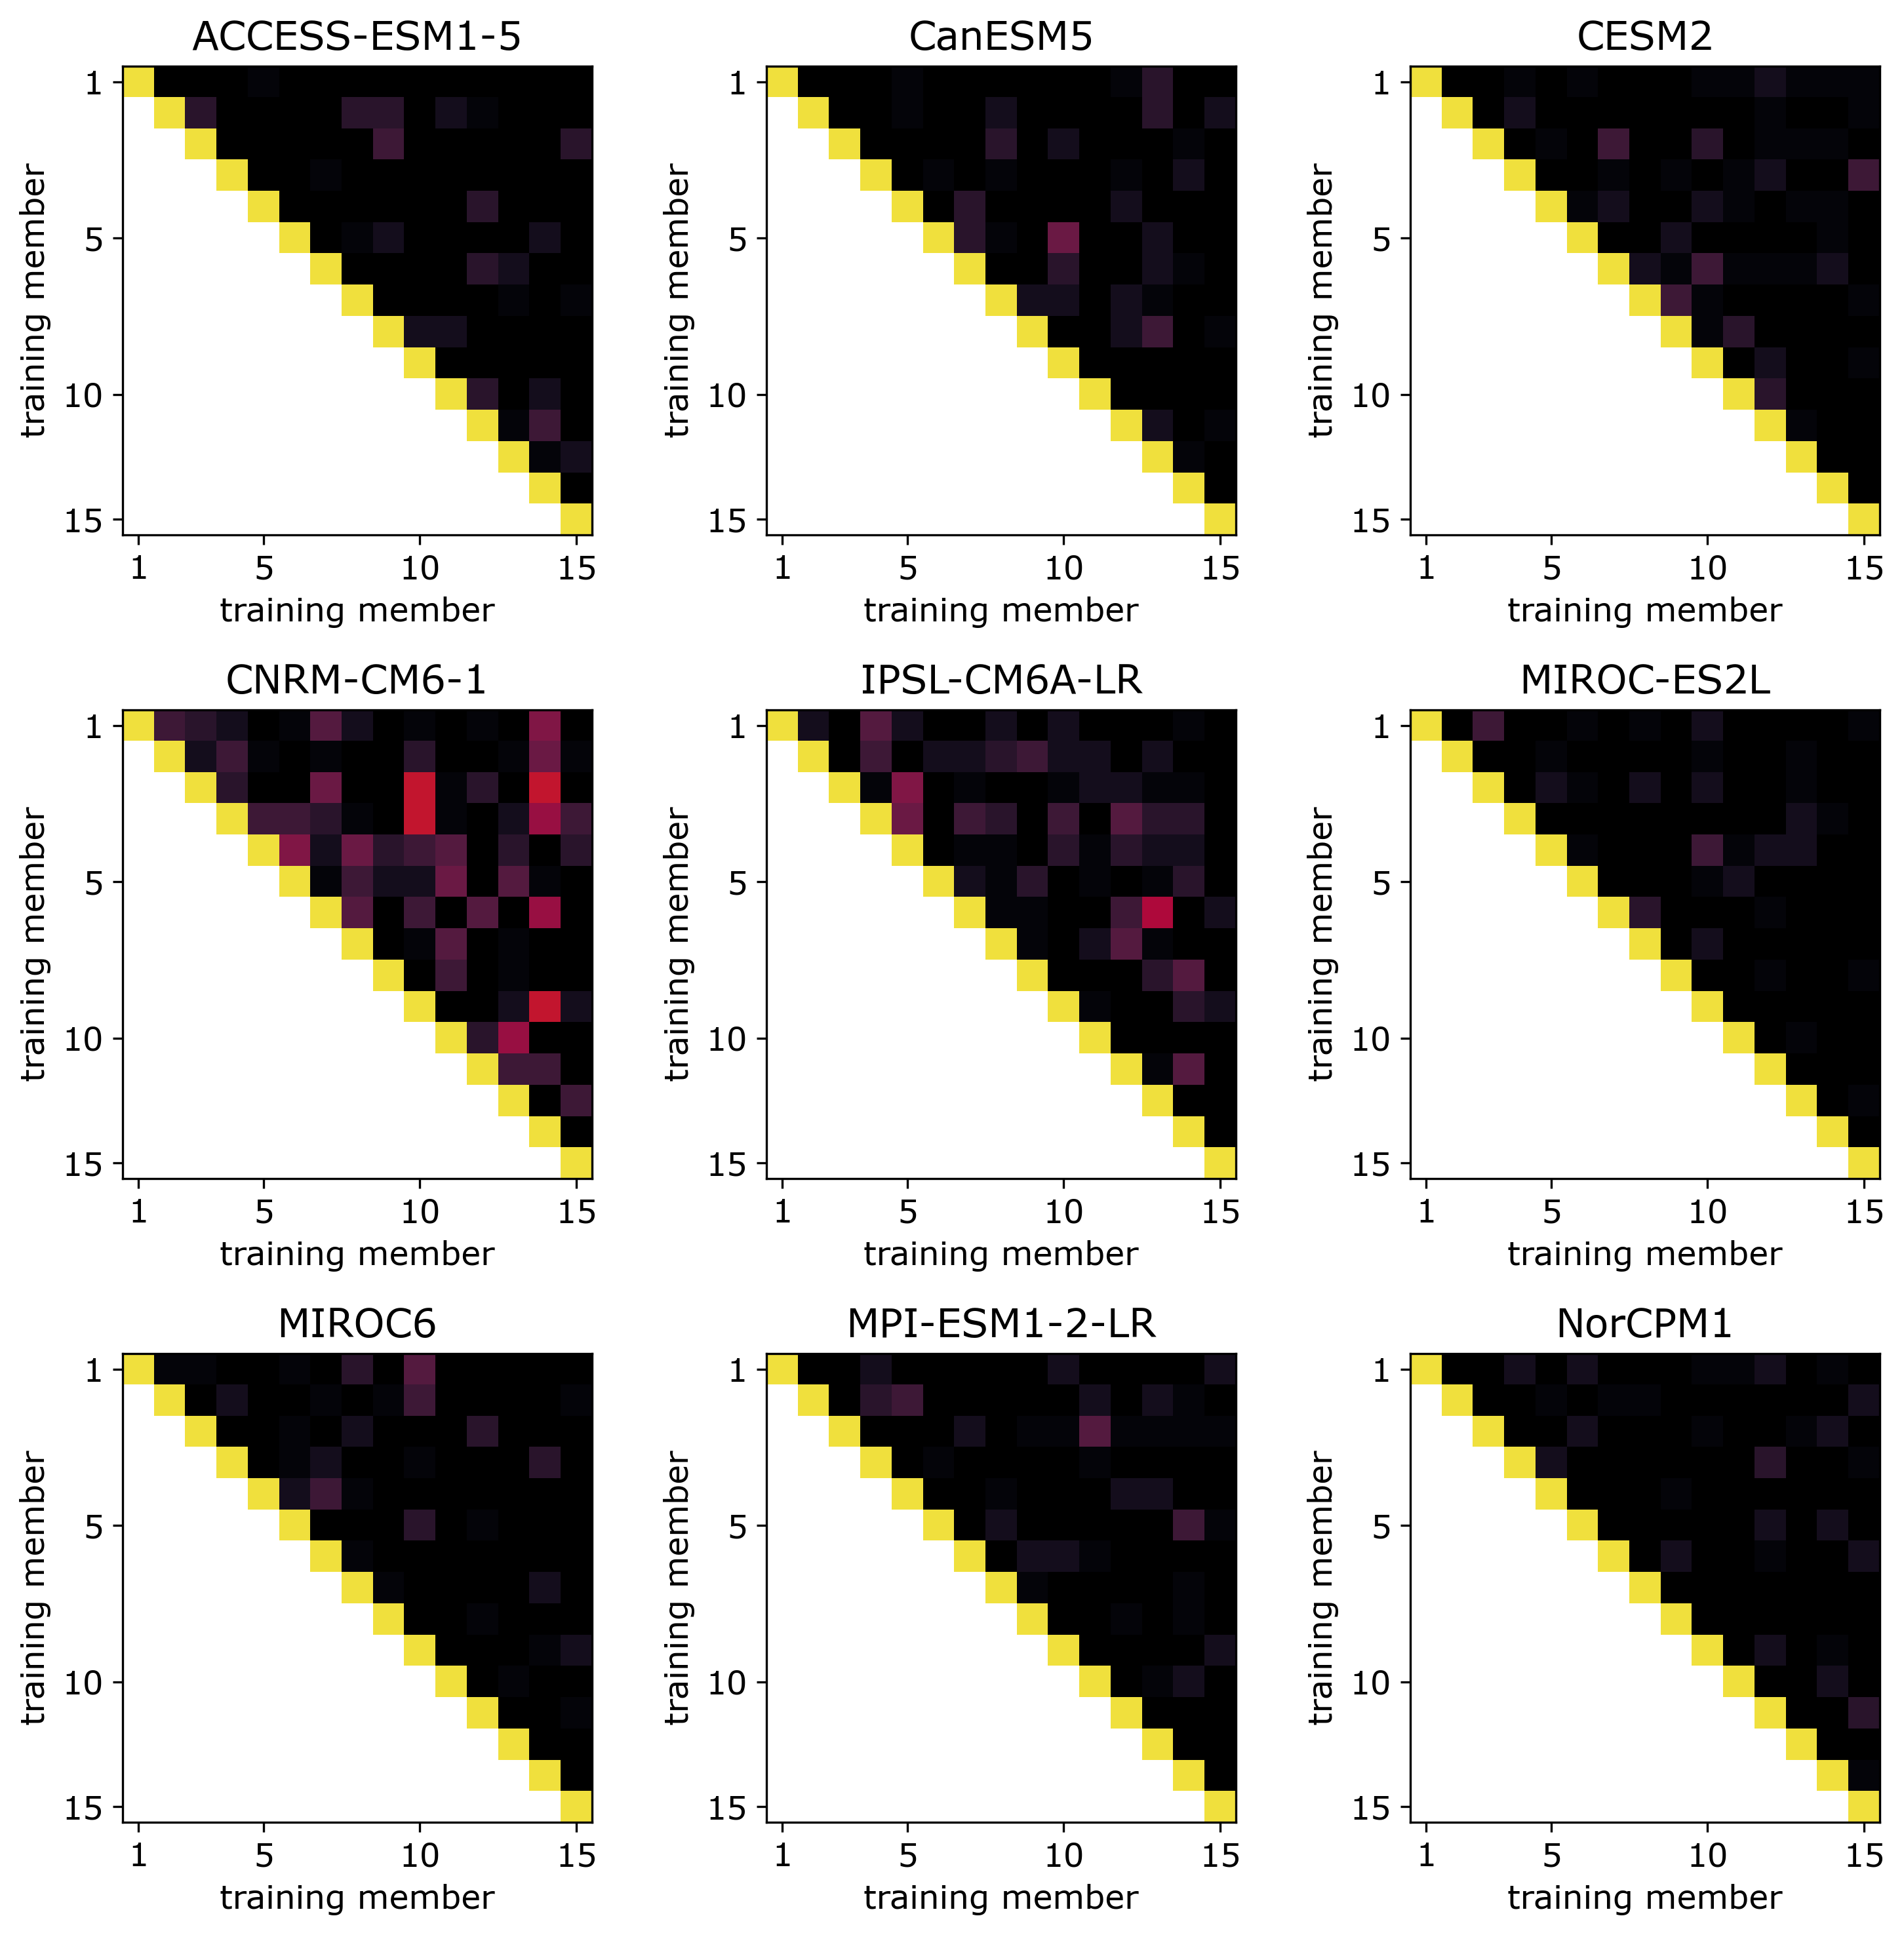

In [11]:
cmapinc = cmr.ember
bounds = np.arange(0,1+0.05,0.05)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmapinc.N)

plt.figure(figsize=(10,10))

for imodel in range(nmodels):

    indmems = reshapengrab(outputdata,imodel,nmodels,15) 
    indmems = np.reshape(indmems,(15,ntimesteps,11,38))
    SCvecs = np.empty((15,ntimesteps))

    for ipattern in range(15):
        SCvecs[ipattern] = allthelinalg.index_timeseries(indmems[ipattern],bestpattern,landmask)
    
    corrmatrix = np.empty((15,15))+np.nan

    for ii in range(15):
        for jj in range(15):
            if ii<=jj:
                corrmatrix[ii,jj],_ = pearsonr(SCvecs[ii],SCvecs[jj])
    
    plt.subplot(3,3,imodel+1)
    plt.imshow((np.flipud(corrmatrix)**2),norm=norm,cmap=cmapinc)
    # plt.colorbar()
    plt.title(modellist[imodel])
    plt.xlabel('training member')
    plt.ylabel('training member')
    plt.xticks([0,4,9,14],["1","5","10","15"])
    plt.yticks([0,4,9,14],["15","10","5","1"])
    plt.ylim(-0.5,14.5)
    plt.xlim(-0.5,14.5)
    # cbar=plt.colorbar()
    # cbar.set_ticks(np.arange(0,1.2,0.2))

plt.tight_layout()
plt.show()


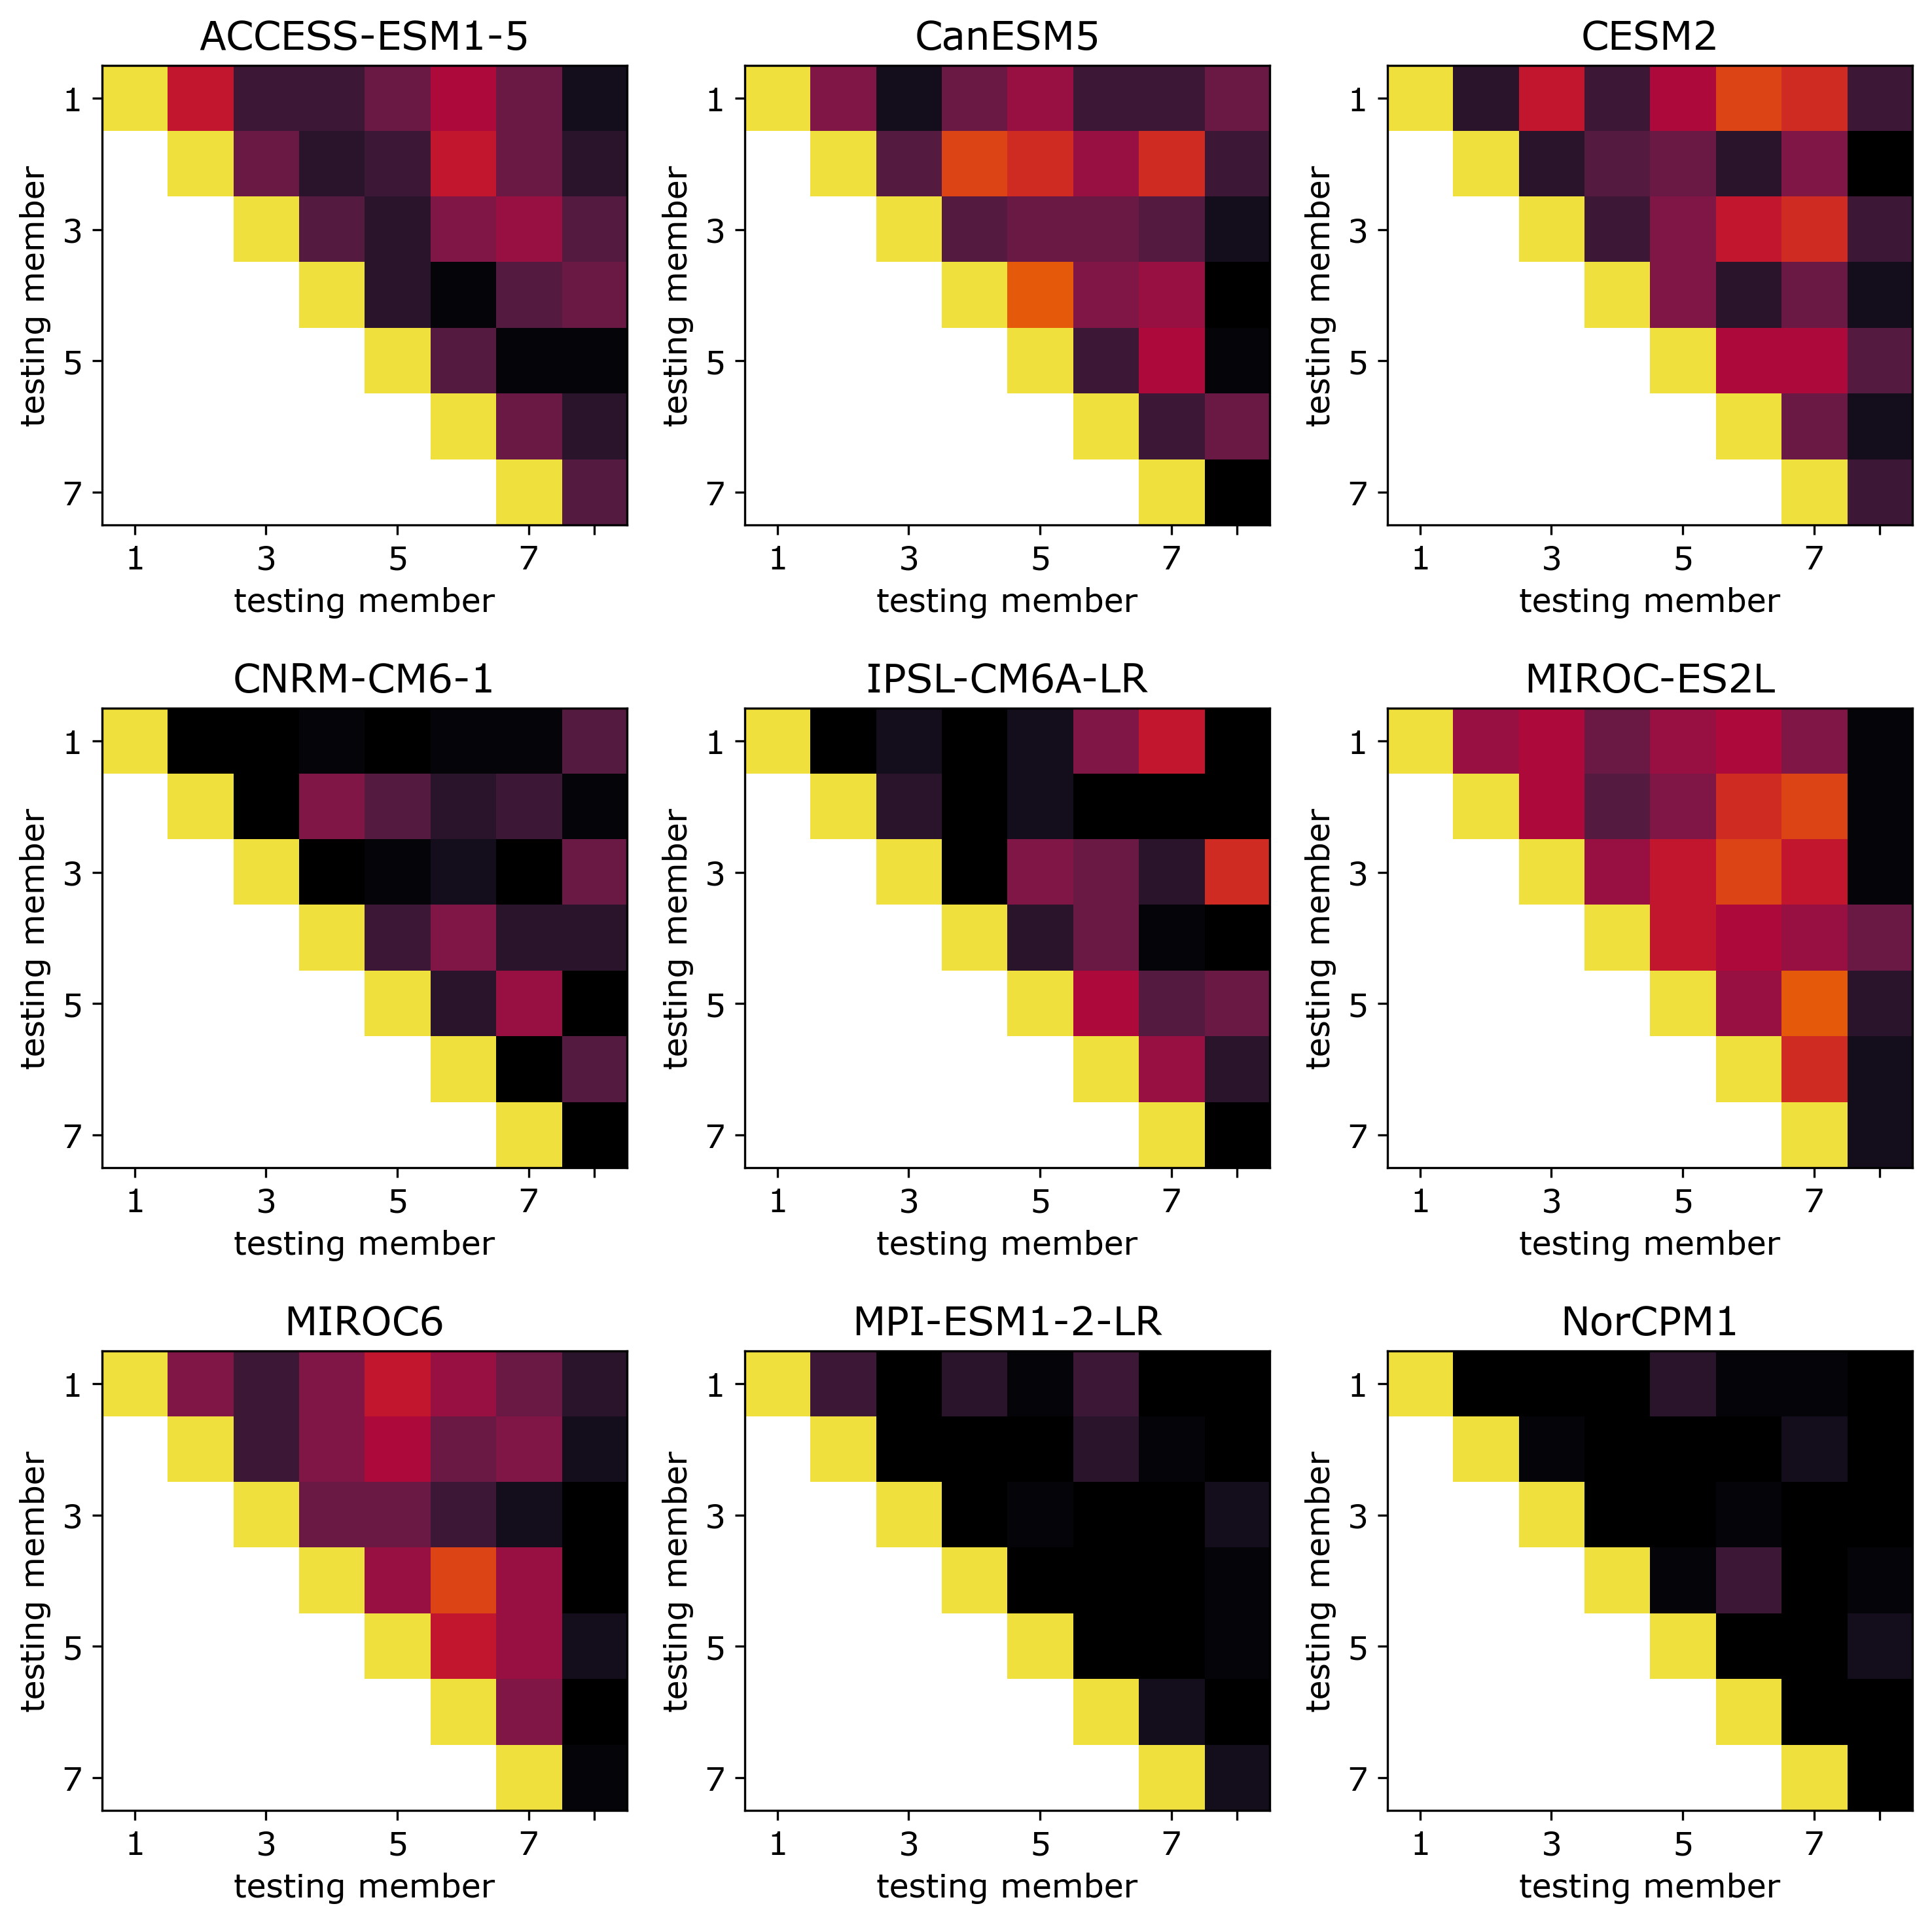

In [12]:
plt.figure(figsize=(10,10))

ERSSTtimeseries = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)

for imodel in range(nmodels):

    indmems = reshapengrab(outputtest_polydetrend,imodel,nmodels,7) 
    indmems = np.reshape(indmems,(7,ntimesteps,11,38))
    SCvecs = np.empty((7,ntimesteps))

    for ipattern in range(7):
        SCvecs[ipattern] = allthelinalg.index_timeseries(indmems[ipattern],bestpattern,landmask)
    
    corrmatrix = np.empty((8,8))+np.nan

    for ii in range(7):
        corrmatrix[ii,-1],_ = pearsonr(SCvecs[ii,3:],ERSSTtimeseries[:-9])
        for jj in range(7):
            if ii<=jj:
                corrmatrix[ii,jj],_ = (pearsonr(SCvecs[ii],SCvecs[jj]))

    plt.subplot(3,3,imodel+1)
    plt.imshow((np.flipud(corrmatrix))**2,norm=norm,cmap=cmapinc)
    # plt.colorbar()
    plt.title(modellist[imodel])
    plt.xlabel('testing member')
    plt.ylabel('testing member')
    plt.xticks([0,2,4,6,7],["1","3","5","7",""])
    plt.yticks([1,3,5,7],["7","5","3","1"])
    plt.ylim(0.5,7.5)
    plt.xlim(-0.5,7.5)
    # cbar=plt.colorbar()
    # cbar.set_ticks(np.arange(0,1.2,0.2))

plt.tight_layout()
plt.show()


In [13]:
def decileerror(vecpred,vectrue):
    deciles = np.arange(0,100,10)

    reliability = np.empty(10)
    decvals = np.empty(11)

    for idec,dec in enumerate(deciles):
        lowerbound = np.percentile(vecpred,dec)
        upperbound = np.percentile(vecpred,dec+10)

        decvals[idec] = np.percentile(vecpred,dec)

        maedec = np.mean((vecpred[(vecpred>=lowerbound) & (vecpred<upperbound)] - vectrue[
            (vecpred>=lowerbound) & (vecpred<upperbound)])**2)

        reliability[idec] = maedec  
    
    decvals[-1] = np.percentile(vecpred,100)

    return reliability,decvals


def decileerror_verification(vecpred,vectrue,setdeciles):

    reliability = np.empty(10)

    for idec,dec in enumerate(setdeciles[:-1]):

        maedec = np.mean((vecpred[(vecpred>=dec) & (vecpred<setdeciles[idec+1])] - vectrue[
            (vecpred>=dec) & (vecpred<setdeciles[idec+1])])**2)

        reliability[idec] = maedec  
    
    return reliability


/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


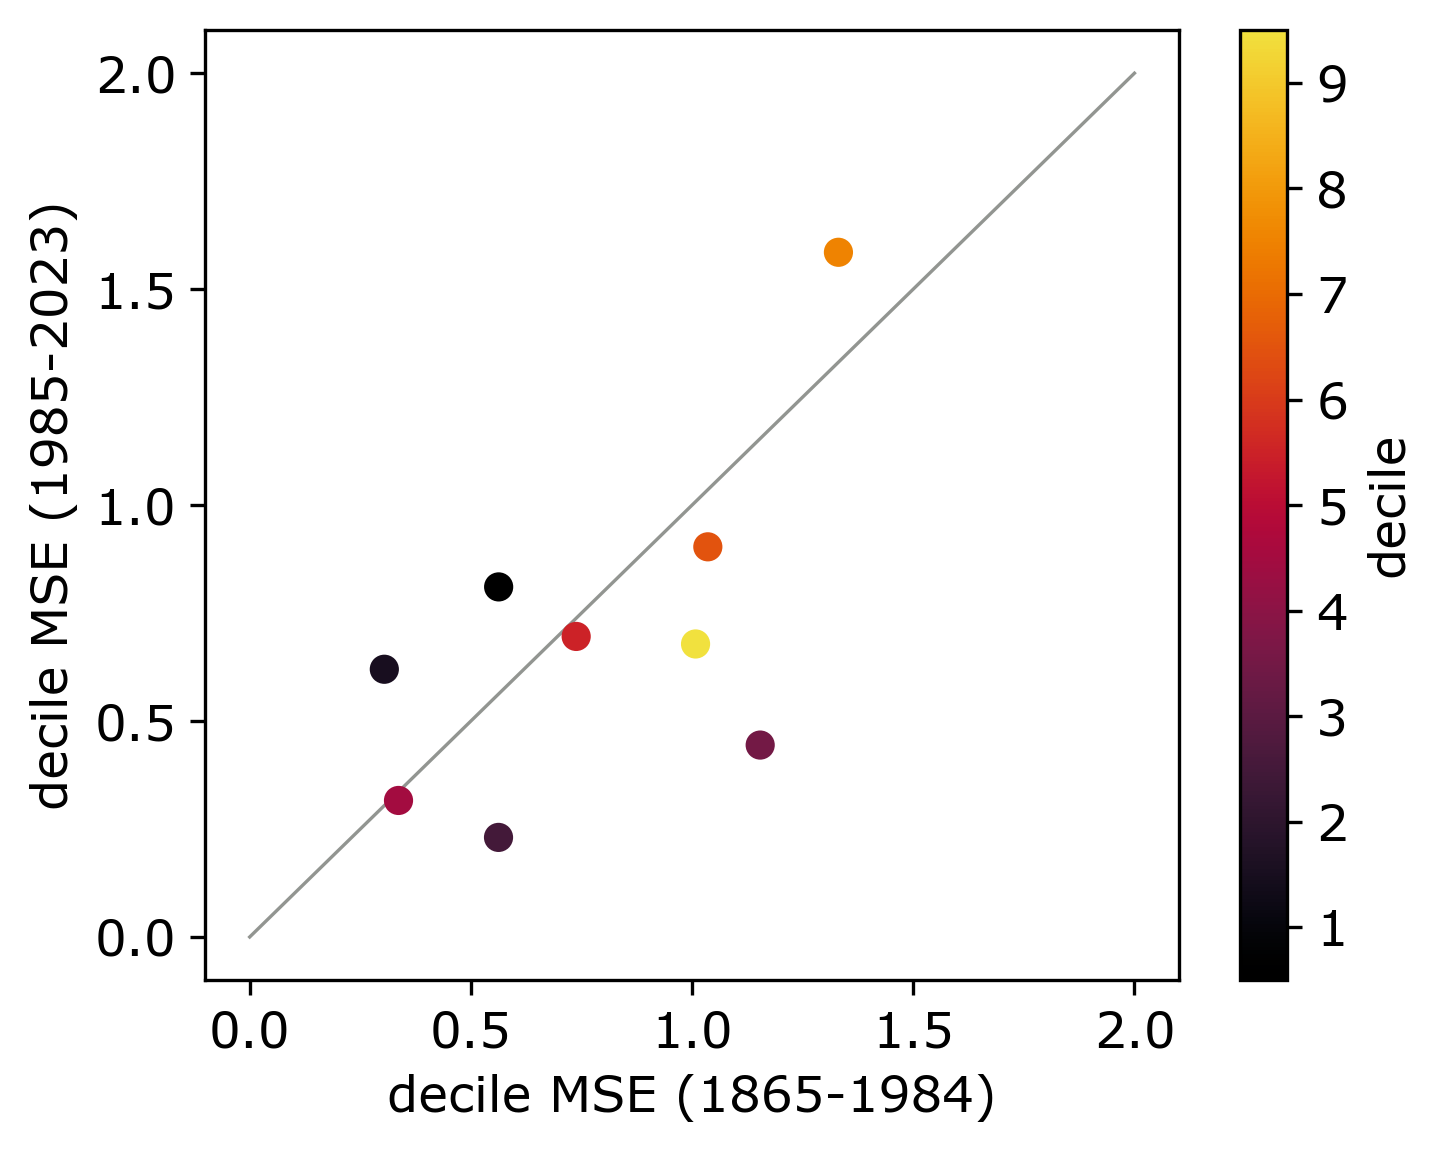

In [20]:
obstimeseries_ERSST_pred = allthelinalg.index_timeseries(y_pred_obs_ERSST,bestpattern,landmask)
obstimeseries_ERSST_true = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)

obstimeseries_HadISST_pred = allthelinalg.index_timeseries(y_pred_obs_HadISST,bestpattern,landmask)
obstimeseries_HadISST_true = allthelinalg.index_timeseries(outputobs_HadISST,bestpattern,landmask)

ERSSTreliability,dcvals = decileerror(obstimeseries_ERSST_pred[:int(1.5*len(obstimeseries_ERSST_pred)/2)],obstimeseries_ERSST_true[:int(1.5*len(obstimeseries_ERSST_pred)/2)])
ERSSTverificationreliability = decileerror_verification(obstimeseries_ERSST_pred[int(1.5*len(obstimeseries_ERSST_pred)/2):],
                                                        obstimeseries_ERSST_true[int(1.5*len(obstimeseries_ERSST_pred)/2):],dcvals)


plt.figure(figsize=(5,4))
plt.scatter(ERSSTreliability,ERSSTverificationreliability,c=np.arange(0.5,10.5,1),cmap=cmr.ember,zorder=1)
plt.plot(np.arange(0,3),np.arange(0,3),color='xkcd:grey',linewidth=0.8,zorder=0)
plt.xticks(np.arange(0,2.5,0.5))
plt.yticks(np.arange(0,2.5,0.5))
plt.xlabel('decile MSE (1865-1984)')
plt.ylabel('decile MSE (1985-2023)')
cbar=plt.colorbar()
cbar.ax.set_ylabel('decile')

plt.tight_layout()
plt.savefig("../figures/reliability.png",dpi=200)

# obstimeseries_HadISST_true = allthelinalg.index_timeseries(outputobs_HadISST,bestpattern,landmask)
# obstimeseries_HadISST_pred = allthelinalg.index_timeseries(y_pred_obs_HadISST,bestpattern,landmask)

# HadISSTreliability,dcvals = decileerror(obstimeseries_HadISST_pred,obstimeseries_HadISST_true)


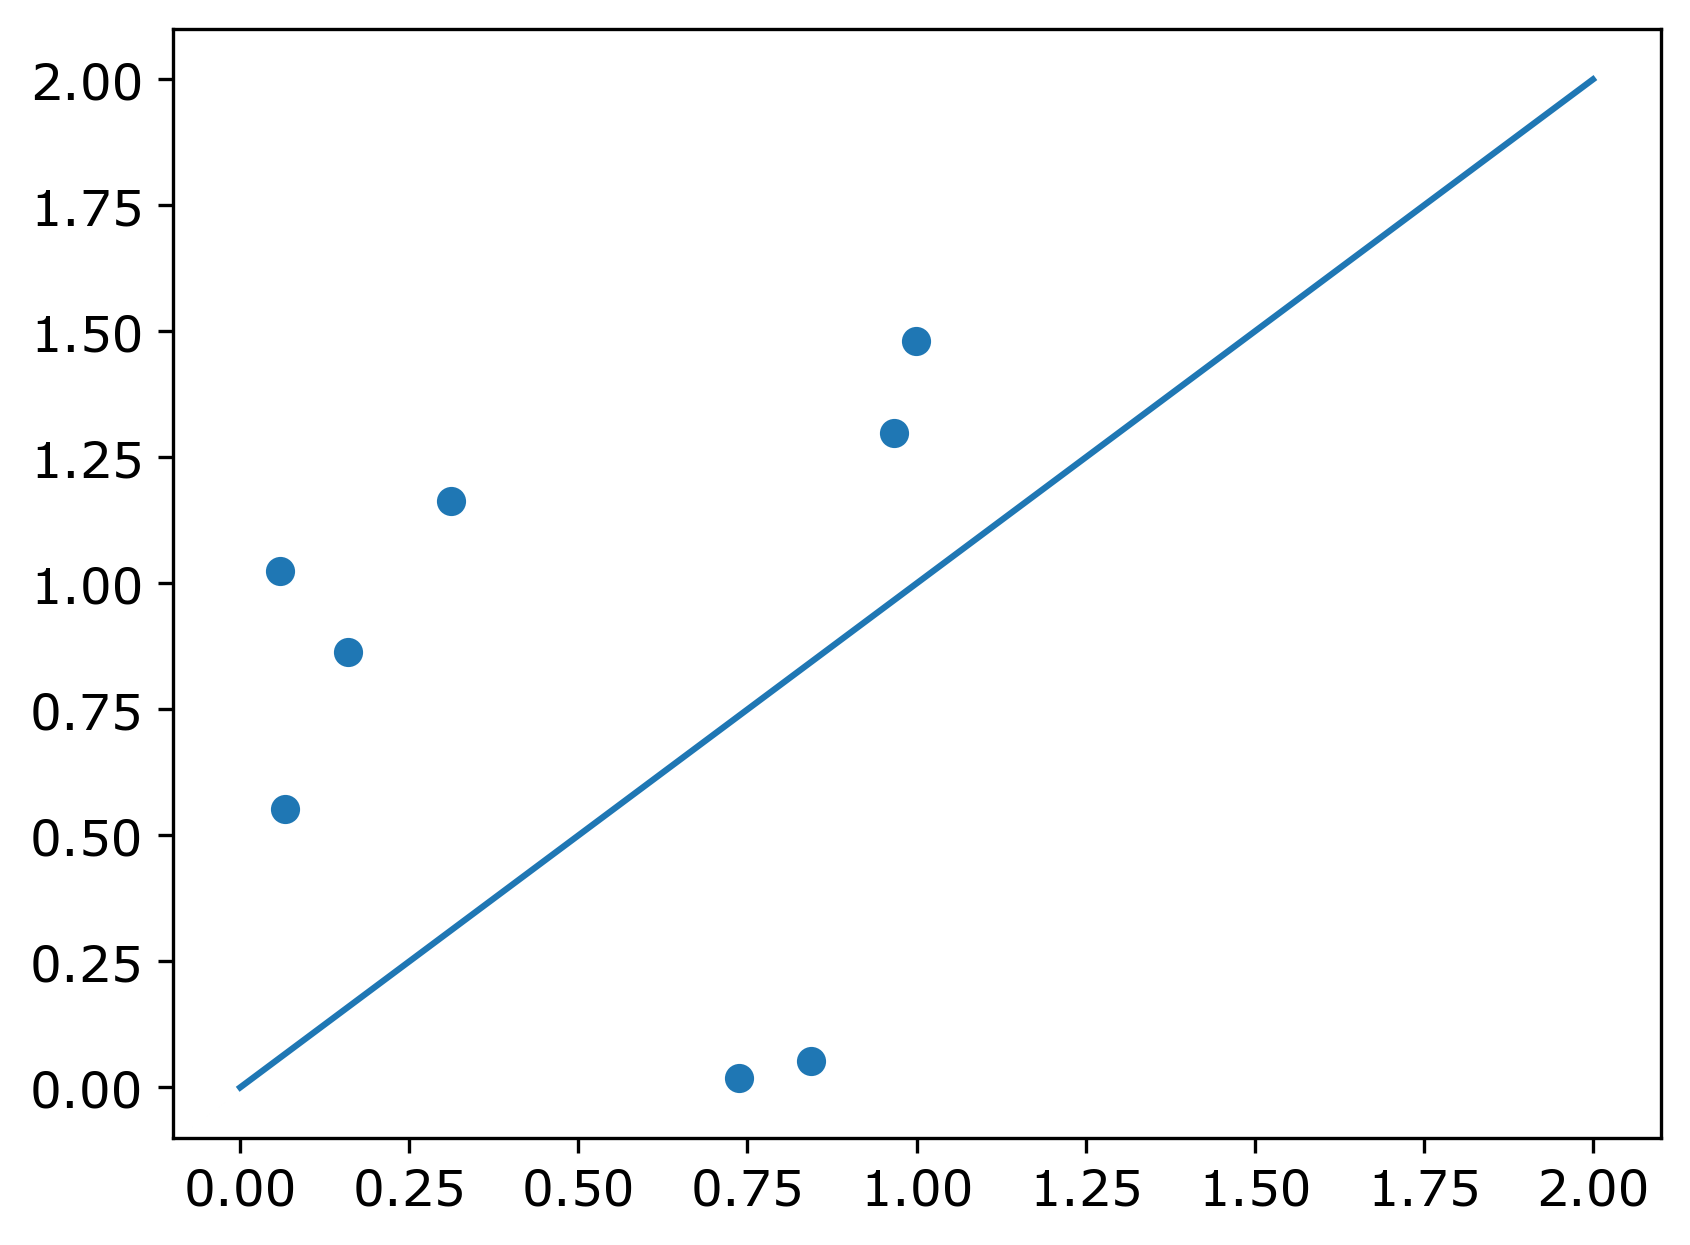

In [18]:
HadISSTreliability,dcvals = decileerror(obstimeseries_HadISST_pred[:int(1.5*len(obstimeseries_HadISST_pred)/2)],obstimeseries_HadISST_true[:int(1.5*len(obstimeseries_HadISST_pred)/2)])
HadISSTverificationreliability = decileerror_verification(obstimeseries_HadISST_pred[int(1.5*len(obstimeseries_HadISST_pred)/2):],
                                                        obstimeseries_HadISST_true[int(1.5*len(obstimeseries_HadISST_pred)/2):],dcvals)



plt.scatter(HadISSTreliability,HadISSTverificationreliability)
plt.plot(np.arange(0,3),np.arange(0,3))


In [ ]:
dcvals.shape

(11,)